In [1]:
!pip install python-graphblas[default]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.9/350.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 13.7 MB/s eta 0:00:00


In [2]:
import graphblas as gb
gb.init("suitesparse", blocking=False)
from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder, Vector
from graphblas.io import mmread
import numpy as np
import random
import math

# Обязательные задачи

Везде считаем, что вершины графа занумерованы подряд с нуля. Обратите внимание на то, что про граф заранее не известно, есть ли в нём циклы отрицательного веса.

1. Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford).
 <br> $\cdot$ Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и номер стартовой вершины.
 <br> $\cdot$ Функция возвращает массив, где для каждой вершины указано расстояние до неё от указанной стартовой вершины. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

2. Используя python-graphblas реализовать функцию поиска кратчайших путей в ориентированном графе из заданной вершины (Bellman–Ford).
 <br> $\cdot$ Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
 <br> $\cdot$ Функция возвращает массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

3. Используя python-graphblas реализовать две функции поиска кратчайших путей в ориентированном графе для всех пар вершин (Floyd–Warshall и вычисление транзитивного замыкания).
 <br> $\cdot$ Функции принимают представление графа, удобное для неё (загрузка, конвертация реализованы отдельно).
 <br> $\cdot$ Функции возвращают массив пар: вершина, и массив, где для каждой вершины указано расстояние до неё из указанной. Если вершина не достижима или кратчайшего пути для неё не существует, то значение соответствующей ячейки равно float('inf').

##Реализация задачи 1
**Базовый алгоритм Белмана-Форда**

In [3]:
# Порядок работы функции

# функция принимает граф и заданную вершину
# на первом шаге создаётся вектор типа и размерности обрабатываемой матрицы
# координата вектора, соответствующая начальной вершине инициализируется нулём
# в цикле while конструируется алгоритм обхода графа, где операция
# матричного умножения с использованием полукольца выполняет один шаг
# поиска в ширину.
# проверяется наличие циклов отрицательного веса
# при их наличии выводится соответствующее сообщение
# далее формируется результат работы функции установленного вида

def bellman_and_ford(matrix, vertex):
  v = Vector(matrix.dtype, matrix.nrows)
  v[vertex] << 0
  w = v.dup()
  while True:
    w_old = w.dup()
    w(binary.min) << w.vxm(matrix, semiring.min_plus)
    if w.isequal(w_old):
        break
  w_old = w.dup()
  w(binary.min) << w.vxm(matrix, semiring.min_plus)
  if not w.isequal(w_old):
    raise ValueError("Есть цикл отрицательного веса")
  result = []
  for i in range(matrix.nrows):
    if w[i].value is None:
      result.append(float('inf'))
    else:
      result.append(w[i].value)
  return result

##Реализация задачи 2
**Алгоритм Белмана-Форда для нескольких начальных вершин**

In [69]:
# Порядок работы функции

# теперь функция вместо номера вершины принимает массив номеров вершин
# следствием этого является то, что теперь данные собираются не в вектор, а в матрицу
# цикл while усложняется вложенным диклом for
# аналогичное дополнение появляется в блоке функции,
# отвечающем за проверку графа на наличие цикла отрицательного веса

def bellman_and_ford_array(matrix, vert_arr):
  n = matrix.nrows
  m = len(vert_arr)
  v = Matrix(dtypes.UINT64, m, n)
  for i in range(m):
    v[i,vert_arr[i]] << 0
  w = v.dup()
  while True:
    w_old = w.dup()
    for i in range(m):
      w[i,:](binary.min) << w[i,:].vxm(matrix, semiring.min_plus)
    if w.isequal(w_old):
        break
  w_old = w.dup()
  for i in range(m):
    w[i,:](binary.min) << w[i,:].vxm(matrix, semiring.min_plus)
  if not w.isequal(w_old):
    raise ValueError("Есть цикл отрицательного веса")
  result = {}
  for i in range(m):
    values = []
    for j in range(n):
      if w[i, j].value is None:
        values.append(float('inf'))
      else:
        values.append(w[i, j].value)
    result[vert_arr[i]] = (values)
  return result

##Тестирование двух вариантов функций Белмана-Форда

**Для тестирования будем использовать набор графов, используемый для тестирования в двух первых лабораторных работах**

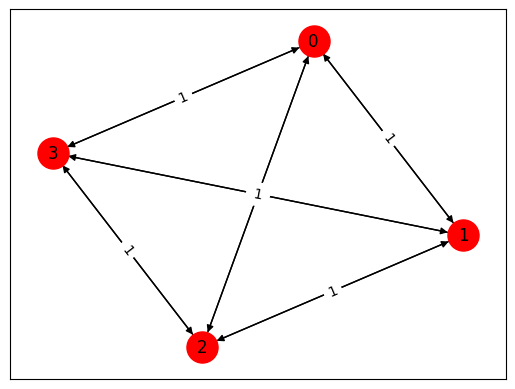

In [68]:
# Построим полносвязный планарный граф с четырьмя вершинами
# Он должен быть как треугольник с одной вершиной внутри трегульника (чтобы быть планарным)
# К сожалению программа отрисовывает его в непланарном виде

M1 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 3, 1, 3, 0],
  [1, 0, 2, 1, 0, 2, 3, 2, 1, 3, 0, 3],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=4, ncols=4,)

gb.viz.draw(M1)

In [84]:
vert = 3
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M1, vert))
print()
vertex_arr = [0, 3]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M1, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  3
Массив расстояний:  [1, 1, 1, 0]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [0, 3]
Массив расстояний:  {0: [0, 1, 1, 1], 3: [1, 1, 1, 0]}


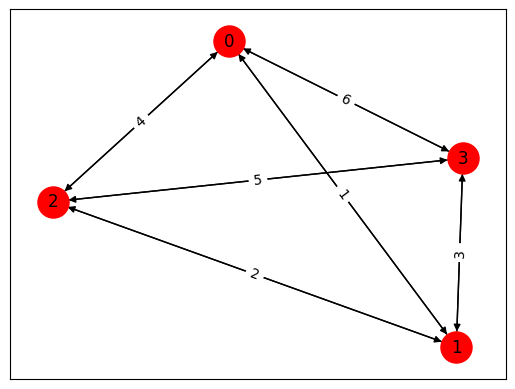

In [8]:
# Изменим веса на предыдущем графе

M1_2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 3, 1, 3, 0],
  [1, 0, 2, 1, 0, 2, 3, 2, 1, 3, 0, 3],
  [1, 1, 2, 2, 4, 4, 5, 5, 3, 3, 6, 6],
  nrows=4, ncols=4,)

gb.viz.draw(M1_2)

In [71]:
vert = 1
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M1_2, vert))
print()
vertex_arr = [0, 3]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M1_2, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  1
Массив расстояний:  [1, 0, 2, 3]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [0, 3]
Массив расстояний:  {0: [0, 1, 3, 4], 3: [4, 3, 5, 0]}


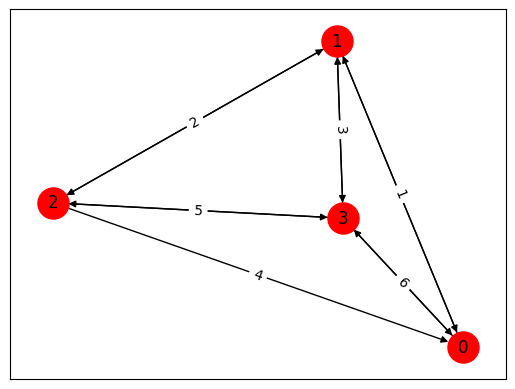

In [22]:
# Удалим на предыдущем графе связь 0 -> 2

M1_3 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 2, 3, 3, 1, 3, 0],
  [1, 0, 2, 1, 0, 3, 2, 1, 3, 0, 3],
  [1, 1, 2, 2, 4, 5, 5, 3, 3, 6, 6],
  nrows=4, ncols=4,)

gb.viz.draw(M1_3)

In [74]:
vert = 0
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M1_2, vert))
print()
vertex_arr = [0, 3]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M1_3, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  0
Массив расстояний:  [0, 1, 3, 4]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [0, 3]
Массив расстояний:  {0: [0, 1, 3, 4], 3: [4, 3, 5, 0]}


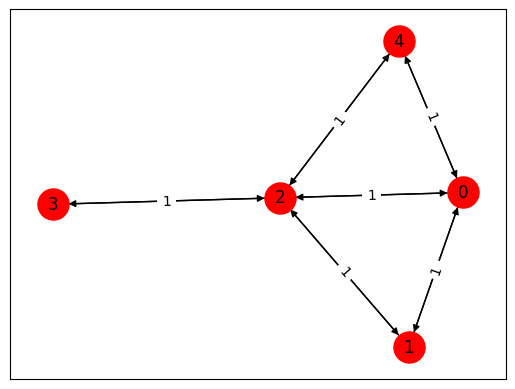

In [24]:
# Граф - воздушный змей
# (с единичными весами всех связей)

M2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 4, 0, 4, 2],
  [1, 0, 2, 1, 0, 2, 3, 2, 0, 4, 2, 4],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=5, ncols=5,)

gb.viz.draw(M2)

In [76]:
vert = 0
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M2, vert))
print()
vertex_arr = [0, 2, 3]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M2, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  0
Массив расстояний:  [0, 1, 1, 2, 1]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [0, 2, 3]
Массив расстояний:  {0: [0, 1, 1, 2, 1], 2: [1, 1, 0, 1, 1], 3: [2, 2, 1, 0, 2]}


In [77]:
vert = 3
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M2, vert))
print()
vertex_arr = [1, 4]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M2, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  3
Массив расстояний:  [2, 2, 1, 0, 2]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [1, 4]
Массив расстояний:  {1: [1, 0, 1, 2, 2], 4: [1, 2, 1, 2, 0]}


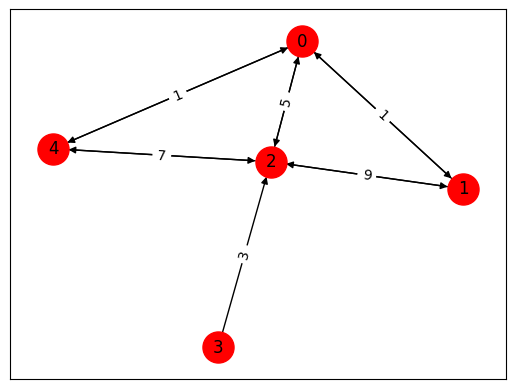

In [30]:
# Изменим некоторые веса

M2_2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 3, 4, 0, 4, 2],
  [1, 0, 2, 1, 0, 2, 2, 0, 4, 2, 4],
  [1, 1, 9, 9, 5, 5, 3, 1, 1, 7, 7],
  nrows=5, ncols=5,)

gb.viz.draw(M2_2)

In [78]:
vert = 3
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M2_2, vert))
print()
vertex_arr = [0, 2, 3]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M2_2, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  3
Массив расстояний:  [8, 9, 3, 0, 9]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [0, 2, 3]
Массив расстояний:  {0: [0, 1, 5, inf, 1], 2: [5, 6, 0, inf, 6], 3: [8, 9, 3, 0, 9]}


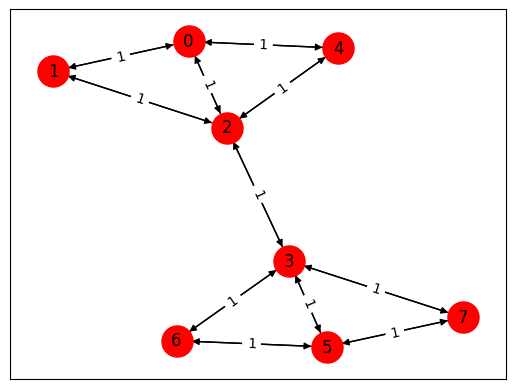

In [32]:
# Граф - два воздушных змея, связанных верёвочкой

M3 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 4, 0, 4, 2, 3, 5, 3, 6, 5, 6, 3, 7, 5, 7],
  [1, 0, 2, 1, 0, 2, 3, 2, 0, 4, 2, 4, 5, 3, 6, 3, 6, 5, 7, 3, 7, 5],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=8, ncols=8,)

gb.viz.draw(M3)

In [79]:
vert = 0
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M3, vert))
print()
vertex_arr = [0, 1, 5]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M3, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  0
Массив расстояний:  [0, 1, 1, 2, 1, 3, 3, 3]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [0, 1, 5]
Массив расстояний:  {0: [0, 1, 1, 2, 1, 3, 3, 3], 1: [1, 0, 1, 2, 2, 3, 3, 3], 5: [3, 3, 2, 1, 3, 0, 1, 1]}


In [80]:
vert = 3
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M3, vert))
print()
vertex_arr = [2, 3]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M3, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  3
Массив расстояний:  [2, 2, 1, 0, 2, 1, 1, 1]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [2, 3]
Массив расстояний:  {2: [1, 1, 0, 1, 1, 2, 2, 2], 3: [2, 2, 1, 0, 2, 1, 1, 1]}


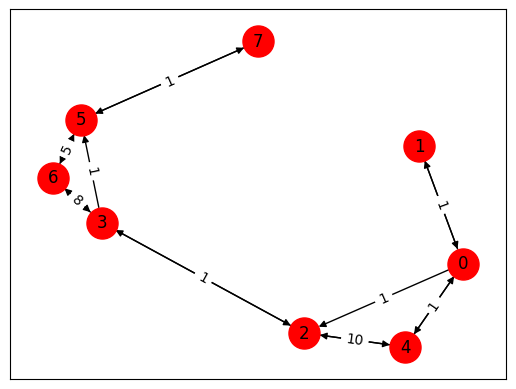

In [60]:
# Граф - два воздушных змея, связанных верёвочкой
# Изменим веса и уберём некоторые связи
# в частности, 1 <-> 2, 3 <-> 7

M3_2 = gb.Matrix.from_coo(
  [0, 1, 0, 2, 3, 4, 0, 4, 2, 3, 3, 6, 5, 6, 5, 7],
  [1, 0, 2, 3, 2, 0, 4, 2, 4, 5, 6, 3, 6, 5, 7, 5],
  [1, 1, 1, 1, 1, 1, 1, 10, 10, 1, 8, 8, 5, 5, 1, 1],
  nrows=8, ncols=8,)

gb.viz.draw(M3_2)

In [81]:
vert = 3
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M3_2, vert))
print()
vertex_arr = [1, 7]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M3_2, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  3
Массив расстояний:  [12, 13, 1, 0, 11, 1, 6, 2]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [1, 7]
Массив расстояний:  {1: [1, 0, 2, 3, 2, 4, 9, 5], 7: [26, 27, 15, 14, 25, 1, 6, 0]}


In [82]:
vert = 7
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M3_2, vert))
print()
vertex_arr = [6, 4]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M3_2, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  7
Массив расстояний:  [26, 27, 15, 14, 25, 1, 6, 0]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [6, 4]
Массив расстояний:  {6: [20, 21, 9, 8, 19, 5, 0, 6], 4: [1, 2, 2, 3, 0, 4, 9, 5]}


In [83]:
vert = 1
print('Алгоритм Белмана-Форда')
print('Стартовая вершина: ', vert)
print('Массив расстояний: ', bellman_and_ford(M3_2, vert))
print()
vertex_arr = [0, 3, 5]
print('Алгоритм Белмана-Форда для нескольких вершин')
print('Стартовые вершины: ', vertex_arr)
print('Массив расстояний: ', bellman_and_ford_array(M3_2, vertex_arr))

Алгоритм Белмана-Форда
Стартовая вершина:  1
Массив расстояний:  [1, 0, 2, 3, 2, 4, 9, 5]

Алгоритм Белмана-Форда для нескольких вершин
Стартовые вершины:  [0, 3, 5]
Массив расстояний:  {0: [0, 1, 1, 2, 1, 3, 8, 4], 3: [12, 13, 1, 0, 11, 1, 6, 2], 5: [25, 26, 14, 13, 24, 0, 5, 1]}


###Вывод:
<br> Построенные функции работают корректно и выдают верный результат.

##Реализация задачи 3
**Алгоритм Флойда-Уоршала**

In [86]:
# Порядок работы функции

# функция принимает матрицу графа
# с матрицы снимается количество строк
# далее создаются две копии матрицы, используемые в дальнейших вычислениях
# запускается основной цикл for, имещий число итераций,
# равное числу строк исходной матрицы
# Затем проверяется наличие циклов отрицательного веса.
# В конце функции собранные данные форматируются для корректного вывода

def floyd_and_warshall(matrix):
  n = matrix.nrows
  w = matrix.dup()
  w_cur = matrix.dup()
  for i in range(n):
    w_c = Matrix(dtypes.INT32, n, n)
    w_r = Matrix(dtypes.INT32, n, n)
    w_c[:, i] = w[:, i].dup()
    w_r[i, :] = w[i, :].dup()
    w_cur << w_c.mxm(w_r, semiring.min_plus)
    w << w.ewise_add(w_cur, op="min")
  weight = w.dup()
  weight_cur = w_cur.dup()
  weight_c = Matrix(dtypes.INT32, n, n)
  weight_r = Matrix(dtypes.INT32, n, n)
  weight_c[:, i] = weight[:, i].dup()
  weight_r[i, :] = weight[i, :].dup()
  weight_cur << weight_c.mxm(weight_r, semiring.min_plus)
  weight << weight.ewise_add(weight_cur, op="min")
  if not weight.isequal(w):
    raise ValueError("Есть цикл отрицательного веса")
  result = {}
  for i in range(n):
    values = []
    for j in range(n):
      if i == j:
        values.append(0)
      elif w[i,j].value is None:
        values.append(float('inf'))
      else:
        values.append(w[i,j].value)
    result[i] = values
  return result

**Реализация при транзитивном замыкании**

In [87]:
# Порядок работы функции

# в переменную считывается столбцов матрицы графа
# инициализируется целочисленная матрица соответствующего размера
# данная матрица заполняется единицами на главной диагонали
# Далее в цикле for количества итераций, равном количеству вершин графа,
# выполняется основной обход графа
# Производится поиск циклов отрицательного веса.
# В конце выполняется перевод данных в удобную для вывода форму

def transitive_closure(matrix):
  n = matrix.ncols
  I = Matrix(dtypes.INT32, n, n)
  for i in range(n):
    I[i, i] << 1
  w = I.dup()
  for i in range(n):
    new_w = w.dup()
    w << w.mxm(matrix, semiring.min_plus).ewise_add(I, binary.min)
    if w.isequal(new_w):
       break
  w_old = w.dup()
  w_old << w_old.mxm(matrix, semiring.min_plus).ewise_add(I, binary.min)
  if not w.isequal(w_old):
        raise ValueError("Есть цикл отрицательного веса")
  result = {}
  for i in range(n):
      values = []
      for j in range(n):
        if i == j:
          values.append(0)
        elif w[i, j].value is None:
          values.append(float('inf'))
        else:
          values.append(w[i, j].value - 1)
      result[i] = (values)
  return result

##Тестирование двух данных функций

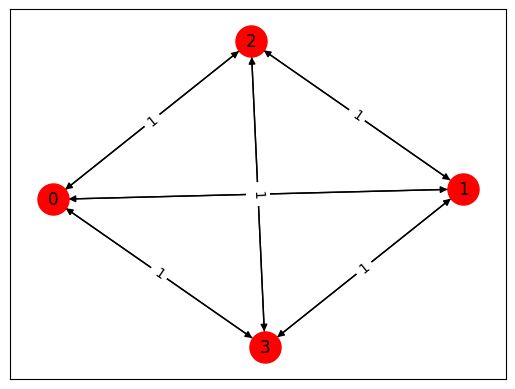

In [85]:
# Построим полносвязный планарный граф с четырьмя вершинами
# Он должен быть как треугольник с одной вершиной внутри трегульника (чтобы быть планарным)
# К сожалению программа отрисовывает его в непланарном виде

M1 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 3, 1, 3, 0],
  [1, 0, 2, 1, 0, 2, 3, 2, 1, 3, 0, 3],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=4, ncols=4,)

gb.viz.draw(M1)

In [89]:
print('Алгоритм Флойда-Уоршала')
print('Result: ', floyd_and_warshall(M1))
print()
print('Алгоритм с транзитивным замыканием')
print('Result: ', transitive_closure(M1))

Алгоритм Флойда-Уоршала
Result:  {0: [0, 1, 1, 1], 1: [1, 0, 1, 1], 2: [1, 1, 0, 1], 3: [1, 1, 1, 0]}

Алгоритм с транзитивным замыканием
Result:  {0: [0, 1, 1, 1], 1: [1, 0, 1, 1], 2: [1, 1, 0, 1], 3: [1, 1, 1, 0]}


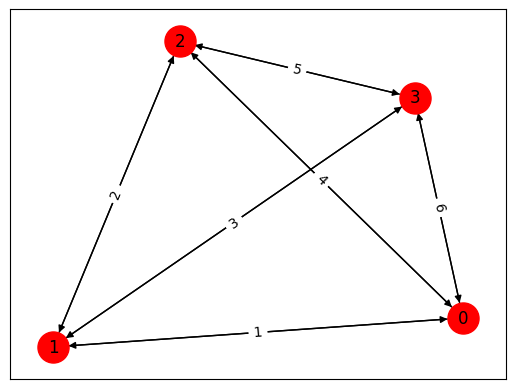

In [90]:
# Изменим веса на предыдущем графе

M1_2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 3, 1, 3, 0],
  [1, 0, 2, 1, 0, 2, 3, 2, 1, 3, 0, 3],
  [1, 1, 2, 2, 4, 4, 5, 5, 3, 3, 6, 6],
  nrows=4, ncols=4,)

gb.viz.draw(M1_2)

In [91]:
print('Алгоритм Флойда-Уоршала')
print('Result: ', floyd_and_warshall(M1_2))
print()
print('Алгоритм с транзитивным замыканием')
print('Result: ', transitive_closure(M1_2))

Алгоритм Флойда-Уоршала
Result:  {0: [0, 1, 3, 4], 1: [1, 0, 2, 3], 2: [3, 2, 0, 5], 3: [4, 3, 5, 0]}

Алгоритм с транзитивным замыканием
Result:  {0: [0, 1, 3, 4], 1: [1, 0, 2, 3], 2: [3, 2, 0, 5], 3: [4, 3, 5, 0]}


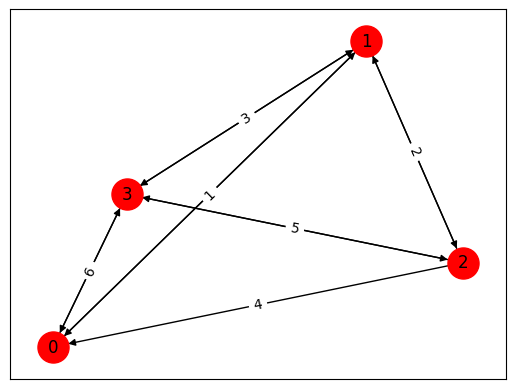

In [92]:
# Удалим на предыдущем графе связь 0 -> 2

M1_3 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 2, 3, 3, 1, 3, 0],
  [1, 0, 2, 1, 0, 3, 2, 1, 3, 0, 3],
  [1, 1, 2, 2, 4, 5, 5, 3, 3, 6, 6],
  nrows=4, ncols=4,)

gb.viz.draw(M1_3)

In [93]:
print('Алгоритм Флойда-Уоршала')
print('Result: ', floyd_and_warshall(M1_3))
print()
print('Алгоритм с транзитивным замыканием')
print('Result: ', transitive_closure(M1_3))

Алгоритм Флойда-Уоршала
Result:  {0: [0, 1, 3, 4], 1: [1, 0, 2, 3], 2: [3, 2, 0, 5], 3: [4, 3, 5, 0]}

Алгоритм с транзитивным замыканием
Result:  {0: [0, 1, 3, 4], 1: [1, 0, 2, 3], 2: [3, 2, 0, 5], 3: [4, 3, 5, 0]}


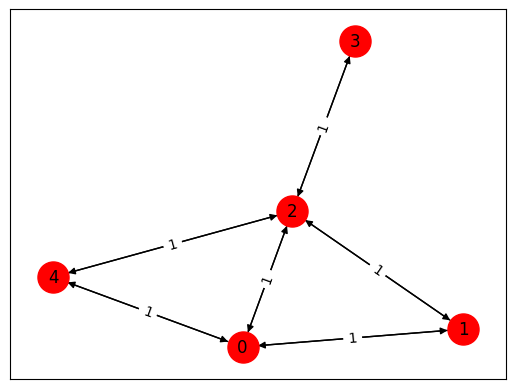

In [94]:
# Граф - воздушный змей
# (с единичными весами всех связей)

M2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 4, 0, 4, 2],
  [1, 0, 2, 1, 0, 2, 3, 2, 0, 4, 2, 4],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=5, ncols=5,)

gb.viz.draw(M2)

In [95]:
print('Алгоритм Флойда-Уоршала')
print('Result: ', floyd_and_warshall(M2))
print()
print('Алгоритм с транзитивным замыканием')
print('Result: ', transitive_closure(M2))

Алгоритм Флойда-Уоршала
Result:  {0: [0, 1, 1, 2, 1], 1: [1, 0, 1, 2, 2], 2: [1, 1, 0, 1, 1], 3: [2, 2, 1, 0, 2], 4: [1, 2, 1, 2, 0]}

Алгоритм с транзитивным замыканием
Result:  {0: [0, 1, 1, 2, 1], 1: [1, 0, 1, 2, 2], 2: [1, 1, 0, 1, 1], 3: [2, 2, 1, 0, 2], 4: [1, 2, 1, 2, 0]}


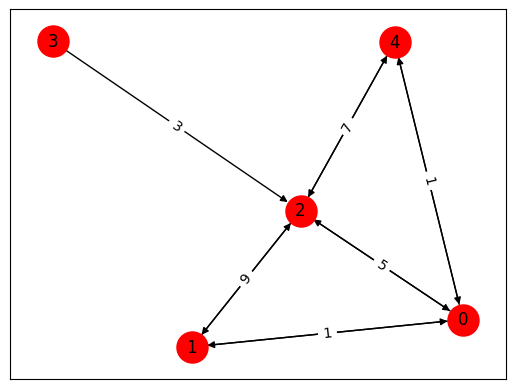

In [96]:
# Изменим некоторые веса

M2_2 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 3, 4, 0, 4, 2],
  [1, 0, 2, 1, 0, 2, 2, 0, 4, 2, 4],
  [1, 1, 9, 9, 5, 5, 3, 1, 1, 7, 7],
  nrows=5, ncols=5,)

gb.viz.draw(M2_2)

In [97]:
print('Алгоритм Флойда-Уоршала')
print('Result: ', floyd_and_warshall(M2_2))
print()
print('Алгоритм с транзитивным замыканием')
print('Result: ', transitive_closure(M2_2))

Алгоритм Флойда-Уоршала
Result:  {0: [0, 1, 5, inf, 1], 1: [1, 0, 6, inf, 2], 2: [5, 6, 0, inf, 6], 3: [8, 9, 3, 0, 9], 4: [1, 2, 6, inf, 0]}

Алгоритм с транзитивным замыканием
Result:  {0: [0, 1, 5, inf, 1], 1: [1, 0, 6, inf, 2], 2: [5, 6, 0, inf, 6], 3: [8, 9, 3, 0, 9], 4: [1, 2, 6, inf, 0]}


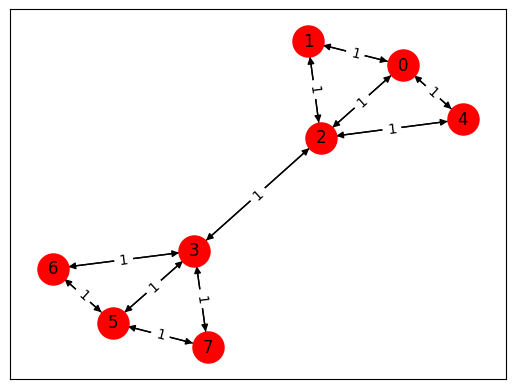

In [98]:
# Граф - два воздушных змея, связанных верёвочкой

M3 = gb.Matrix.from_coo(
  [0, 1, 1, 2, 2, 0, 2, 3, 4, 0, 4, 2, 3, 5, 3, 6, 5, 6, 3, 7, 5, 7],
  [1, 0, 2, 1, 0, 2, 3, 2, 0, 4, 2, 4, 5, 3, 6, 3, 6, 5, 7, 3, 7, 5],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
  nrows=8, ncols=8,)

gb.viz.draw(M3)

In [99]:
print('Алгоритм Флойда-Уоршала')
print('Result: ', floyd_and_warshall(M3))
print()
print('Алгоритм с транзитивным замыканием')
print('Result: ', transitive_closure(M3))

Алгоритм Флойда-Уоршала
Result:  {0: [0, 1, 1, 2, 1, 3, 3, 3], 1: [1, 0, 1, 2, 2, 3, 3, 3], 2: [1, 1, 0, 1, 1, 2, 2, 2], 3: [2, 2, 1, 0, 2, 1, 1, 1], 4: [1, 2, 1, 2, 0, 3, 3, 3], 5: [3, 3, 2, 1, 3, 0, 1, 1], 6: [3, 3, 2, 1, 3, 1, 0, 2], 7: [3, 3, 2, 1, 3, 1, 2, 0]}

Алгоритм с транзитивным замыканием
Result:  {0: [0, 1, 1, 2, 1, 3, 3, 3], 1: [1, 0, 1, 2, 2, 3, 3, 3], 2: [1, 1, 0, 1, 1, 2, 2, 2], 3: [2, 2, 1, 0, 2, 1, 1, 1], 4: [1, 2, 1, 2, 0, 3, 3, 3], 5: [3, 3, 2, 1, 3, 0, 1, 1], 6: [3, 3, 2, 1, 3, 1, 0, 2], 7: [3, 3, 2, 1, 3, 1, 2, 0]}


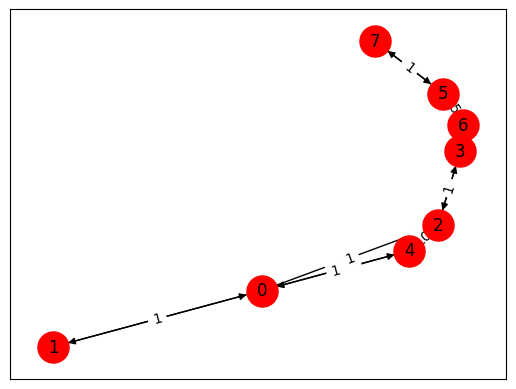

In [103]:
# Граф - два воздушных змея, связанных верёвочкой
# Изменим веса и уберём некоторые связи
# в частности, 1 <-> 2, 3 <-> 7

M3_2 = gb.Matrix.from_coo(
  [0, 1, 0, 2, 3, 4, 0, 4, 2, 3, 3, 6, 5, 6, 5, 7],
  [1, 0, 2, 3, 2, 0, 4, 2, 4, 5, 6, 3, 6, 5, 7, 5],
  [1, 1, 1, 1, 1, 1, 1, 10, 10, 1, 8, 8, 5, 5, 1, 1],
  nrows=8, ncols=8,)

gb.viz.draw(M3_2)

In [101]:
print('Алгоритм Флойда-Уоршала')
print('Result: ', floyd_and_warshall(M3_2))
print()
print('Алгоритм с транзитивным замыканием')
print('Result: ', transitive_closure(M3_2))

Алгоритм Флойда-Уоршала
Result:  {0: [0, 1, 1, 2, 1, 3, 8, 4], 1: [1, 0, 2, 3, 2, 4, 9, 5], 2: [11, 12, 0, 1, 10, 2, 7, 3], 3: [12, 13, 1, 0, 11, 1, 6, 2], 4: [1, 2, 2, 3, 0, 4, 9, 5], 5: [25, 26, 14, 13, 24, 0, 5, 1], 6: [20, 21, 9, 8, 19, 5, 0, 6], 7: [26, 27, 15, 14, 25, 1, 6, 0]}

Алгоритм с транзитивным замыканием
Result:  {0: [0, 1, 1, 2, 1, 3, 8, 4], 1: [1, 0, 2, 3, 2, 4, 9, 5], 2: [11, 12, 0, 1, 10, 2, 7, 3], 3: [12, 13, 1, 0, 11, 1, 6, 2], 4: [1, 2, 2, 3, 0, 4, 9, 5], 5: [25, 26, 14, 13, 24, 0, 5, 1], 6: [20, 21, 9, 8, 19, 5, 0, 6], 7: [26, 27, 15, 14, 25, 1, 6, 0]}


Вывод:
<br> Построенные функции работают корректно.

#Первое дополнительное задание

Провести экспериментальное исследование полученных реализаций на некоторых больших графах в формате Matrix Market с сайта SuiteSparse Matrix Collection и на случайных сгенерированных. При этом описать зависимость времени работы всех полученных реализаций от размеров графа, его степени разреженности, количестве стартовых вершин. В частности выяснить, начиная с какой доли вершин в графе целесообразнее использовать алгоритм поиска кратчайших путей для всех пар вершин вместо того, чтобы решать задачу поиска кратчайших путей из нескольких стартовых (модифицированный Bellman-Ford).

###Тестирование на графах с сайта SuiteSparse Matrix Collection

In [105]:
# читаем 5 графов
graph1 = mmread('/content/bcsstk22.mtx')
graph2 = mmread('/content/can_229.mtx')
graph3 = mmread('/content/dwt_512.mtx')
graph4 = mmread('/content/lshp1009.mtx')
graph5 = mmread('/content/jagmesh3.mtx')

# массив графов
graphs = [graph1, graph2, graph3, graph4, graph5]
# список имён графов
graphs_names = ['bcsstk22', 'can_229', 'dwt_512', 'lshp1009', 'jagmesh3']

In [106]:
# функция подсчета времени выполнения реализованных функций
def alg_time(A, v, v_arr):
  print('bellman_and_ford:')
  %timeit bellman_and_ford(A, v)
  print('bellman_and_ford_array:')
  %timeit bellman_and_ford_array(A, v_arr)
  print('floyd_and_warshall:')
  %timeit floyd_and_warshall(A)
  print('transitive_closure:')
  %timeit transitive_closure(A)

In [108]:
# функция генерации массива стартовых вершин, где n - количество вершин в графе и p - доля генерируемых стартовых вершин
def vertex_generate(n, p):
  points = range(n)
  points_arr = random.sample(points, round(n * p))
  return np.array(points_arr)


gen_vertex = [0.01, 0.05]
cnt = 0
for k in graphs:
  print('Название графа:', graphs_names[cnt], 'Количество вершин:', k.nrows, 'Количество ребер:', k.nvals)
  cnt += 1
  for p in gen_vertex:
    print('Количество стартовых вершин:', round(k.nrows * p))
    print(alg_time(k, random.randint(1, 100), vertex_generate(k.nrows, p)))
  print()

Название графа: bcsstk22 Количество вершин: 138 Количество ребер: 696
Количество стартовых вершин: 1
bellman_and_ford:


Exception ignored in: <function Vector.__del__ at 0x79b6cfc4ad40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/graphblas/core/vector.py", line 191, in __del__
    check_status(lib.GrB_Vector_free(gb_obj), self)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [109]:
bellman_and_ford(graph1, 10)

KeyboardInterrupt: 

In [110]:
# Функция принимает два параметра: количество вершин и разреженность.
# Количество рёбер в случайно генерируемом графе определяется выполнением неравенства,
# состоящего в том, что отношение количества рёбер к максимально возможному количеству
# рёбер при данном количестве вершин не должно превысить значение параметра разреженности
#
# Максимально возможное количество рёбер определяется как число сочетаний (биномиальный
# коэффициент) из количества вершин по 2.
#

def random_graph(n, ro):
    # генерим нужное количество уникальных пар
    limit = math.factorial(n) / (2 * math.factorial(n - 2))
    arr_pairs = []
    while len(arr_pairs) / limit < ro:
        a = random.randint(0, n-1)
        b = random.randint(0, n-1)
        if a == b: continue
        else:
            tmp = [a, b]
            tmp_2 = [b, a]
            if tmp not in arr_pairs and tmp_2 not in arr_pairs:
                arr_pairs.append(tmp)
    #print(arr_pairs)

    # создаём два списка (с обратными парами, чтоб убрать направленность графа)
    cols = []
    rows = []
    for el in arr_pairs:
        cols.append(el[0])
        rows.append(el[1])
        cols.append(el[1])
        rows.append(el[0])

    #print(cols)
    #print(rows)

    vals = [1] * len(cols)
    #print(vals)

    # создаём граф стандартной функцией
    rand_graph = gb.Matrix.from_coo(
    cols, rows, vals, nrows=n, ncols=n)

    return rand_graph

In [111]:
rg_0 = random_graph(30, 0.5)

In [113]:
alg_time(rg_0, 3, [1, 10, 20])

bellman_and_ford:
2.73 ms ± 72.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
bellman_and_ford_array:
13 ms ± 2.4 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
floyd_and_warshall:
106 ms ± 24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
transitive_closure:
79.4 ms ± 464 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [114]:
rg_1 = random_graph(30, 0.2)
alg_time(rg_1, 10, [1, 10, 20])

bellman_and_ford:
3.59 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
bellman_and_ford_array:
14 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
floyd_and_warshall:
107 ms ± 21.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
transitive_closure:
79 ms ± 738 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [115]:
rg_2 = random_graph(30, 0.9)
alg_time(rg_2, 20, [1, 10, 20])

bellman_and_ford:
3.14 ms ± 792 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
bellman_and_ford_array:
12.1 ms ± 1.75 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
floyd_and_warshall:
91.4 ms ± 842 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
transitive_closure:
96.9 ms ± 20 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [116]:
rg_3 = random_graph(60, 0.2)
alg_time(rg_3, 20, [1, 10, 20, 40])

bellman_and_ford:
4.95 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
bellman_and_ford_array:
26.9 ms ± 831 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
floyd_and_warshall:
401 ms ± 86.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
transitive_closure:
401 ms ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
rg_4 = random_graph(60, 0.5)
alg_time(rg_4, 20, [1, 10, 20, 40])

bellman_and_ford:
6.57 ms ± 1.82 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
bellman_and_ford_array:
49.8 ms ± 7.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
floyd_and_warshall:
621 ms ± 202 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
transitive_closure:
701 ms ± 265 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [118]:
rg_5 = random_graph(60, 0.9)
alg_time(rg_5, 20, [1, 10, 20, 40])

bellman_and_ford:
4.96 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
bellman_and_ford_array:
41.1 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
floyd_and_warshall:
348 ms ± 6.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
transitive_closure:
329 ms ± 8.03 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [120]:
rg_6 = random_graph(100, 0.5)
alg_time(rg_6, 50, [1, 10, 20, 40, 50])

bellman_and_ford:
7.98 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
bellman_and_ford_array:
59.2 ms ± 11.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
floyd_and_warshall:
943 ms ± 27.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
transitive_closure:
1.08 s ± 258 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [121]:
rg_7 = random_graph(200, 0.5)
alg_time(rg_7, 50, [1, 10, 20, 40, 50, 100])

bellman_and_ford:
18.2 ms ± 3.02 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
bellman_and_ford_array:
142 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
floyd_and_warshall:
4.13 s ± 545 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
transitive_closure:
4.12 s ± 583 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [122]:
rg_8 = random_graph(200, 0.5)
alg_time(rg_8, 50, [1, 10, 20, 40, 50, 100, 150])

bellman_and_ford:
26.6 ms ± 7.83 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
bellman_and_ford_array:
161 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
floyd_and_warshall:
4.58 s ± 678 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
transitive_closure:
4.06 s ± 556 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


###Выводы по тестированию на больших графах:

1. Результаты тестирования функций, реализующих заданных алгоритмы, показывают, что на случайно сгенерированных графах алгоритм Белмана-Форда имеет преимущество по времени работы  относительно двух других алгоритомов (Флойда-Уоршала и алгоритма с транзитивным замыканием).
2. С ростом числа вершин обрабатываемого графа преимущество алгоритма Белмана-Форда возрастает.
3. На графах относительно небольших размеров алгоритмы показывают примерно сопоставимое время работы.


#Оценить эффект от использования push/pull direction optimization

Не выполнено